In [1]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms as T
from torch.utils import data

In [3]:
from tqdm import tqdm
import os, time, sys
import json

In [4]:
import dtnnlib as dtnn
# import resnet_cifar

In [5]:
mnist_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(
        mean=0.5,
        std=0.5,
    ),
])

train_dataset = datasets.FashionMNIST(root="../../../_Datasets/", train=True, download=True, transform=mnist_transform)
test_dataset = datasets.FashionMNIST(root="../../../_Datasets/", train=False, download=True, transform=mnist_transform)
# train_dataset = datasets.MNIST(root="../../../_Datasets/", train=True, download=True, transform=mnist_transform)
# test_dataset = datasets.MNIST(root="../../../_Datasets/", train=False, download=True, transform=mnist_transform)

In [6]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [7]:
batch_size = 50
train_loader = data.DataLoader(dataset=train_dataset, num_workers=4, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, num_workers=4, batch_size=batch_size, shuffle=False)

In [8]:
device = torch.device("cpu")

In [9]:
for xx, yy in train_loader:
    print(xx.shape)
    xx, yy = xx.view(-1,28*28).to(device), yy.to(device)
    print(xx.shape, yy.shape)
    break

torch.Size([50, 1, 28, 28])
torch.Size([50, 784]) torch.Size([50])


## Train Test method

In [10]:
criterion = nn.CrossEntropyLoss()

In [11]:
## Following is copied from 
### https://github.com/kuangliu/pytorch-cifar/blob/master/main.py

# Training
def train(epoch, model, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs, targets = inputs.to(device).view(-1, 28*28), targets.to(device)
        
        ### Train with random image and "10" as class
#         inputs = torch.cat([inputs, torch.rand(batch_size//10, 28*28, dtype=inputs.dtype).to(device)*2-1], dim=0)
#         targets = torch.cat([targets, torch.ones(batch_size//10, dtype=targets.dtype).to(device)*10], dim=0)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    print(f"[Train] {epoch} Loss: {train_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    return

In [12]:
best_acc = -1
def test(epoch, model, model_name, save=False):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
            inputs, targets = inputs.to(device).view(-1, 28*28), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    print(f"[Test] {epoch} Loss: {test_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'model': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if save:
            if not os.path.isdir('models'):
                os.mkdir('models')
            torch.save(state, f'./models/{model_name}.pth')
        best_acc = acc

## Models

In [13]:
class DistanceTransform_Epsilon(dtnn.DistanceTransformBase):
    
    def __init__(self, input_dim, num_centers, p=2, bias=False, epsilon=0.1):
        super().__init__(input_dim, num_centers, p=2)
        
        nc = num_centers
        if epsilon is not None:
            nc += 1
        self.scaler = nn.Parameter(torch.log(torch.ones(1, 1)*1))
#         self.scaler = nn.Parameter(torch.log(torch.ones(1, nc)*1))
        self.bias = nn.Parameter(torch.ones(1, nc)*0) if bias else None
        self.epsilon = epsilon
        
    def forward(self, x):
        dists = super().forward(x)
        
        if self.epsilon is not None:
            dists = torch.cat([dists, torch.ones(len(x), 1, dtype=x.dtype)*self.epsilon], dim=1)
        
        ### normalize similar to UMAP
#         dists = dists/torch.sqrt(dists.var(dim=1, keepdim=True)+1e-9)
        
    
        #### for norm
#         dists = torch.exp(-dists) ### solves degenerate cases of centers != maxima & also needed for norm
#         dists = -dists + dists.max(dim=1, keepdim=True)[0] ## replacement for e^{-d} -> making similarity (and also better)
#         dists = dists/(torch.norm(dists, dim=1, keepdim=True)/(dists.shape[-1]**0.5)+1e-9)
        
        ## scale the dists
#         dists = torch.exp(-dists.abs()+self.scaler)
        dists = 1-dists*torch.exp(self.scaler) ## use with simple or /std
#         dists = dists*torch.exp(self.scaler) ## use with norm
    
        if self.bias is not None: dists = dists+self.bias
        return dists

In [69]:
class LocalMLP_epsilonsoftmax(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, epsilon=1.0):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.new_hidden_dim = 0
        self.output_dim = output_dim
        
        self.layer0 = DistanceTransform_Epsilon(self.input_dim, self.hidden_dim, bias=True, epsilon=epsilon)
        hdim = self.hidden_dim
        if epsilon is not None:
            hdim += 1
            
#         self.scale_shift = dtnn.ScaleShift(hdim, scaler_init=3, shifter_init=0, scaler_const=True, shifter_const=True)
        self.scale_shift = dtnn.ScaleShift(hdim, scaler_init=10, shifter_init=0, scaler_const=True, shifter_const=True)
        self.softmax = nn.Softmax(dim=-1)
#         self.softmax = F.gumbel_softmax

#         self.activ = dtnn.OneActiv(hdim, mode='exp_1.6', beta_init=np.log(2))
        self.activ = dtnn.OneActiv(hdim, mode='relu', beta_init=np.log(1.2))
#         self.activ = nn.ReLU()

        self.layer1 = nn.Linear(hdim, self.output_dim)
    
        self.temp_maximum = None
        
    def forward(self, x):
        xo = self.layer0(x)
        ## dropout here creates 0 actv (is relatively high), hence serves as noise --> does not work for high values
#         xo = F.dropout(xo, p=0.001, training=self.training)
        xo = self.scale_shift(xo)
        xo = self.softmax(xo)
        self.temp_maximum = xo.data
        
        ## drouout here is suitable for activation function (the probabilities do not add upto 1)
#         xo = F.dropout(xo, p=0.1, training=self.training)
        
        ### This feature is useful when the softmax has uniform and low probability
#         xo = xo/xo.max(dim=1, keepdim=True)[0].detach() ## produces poor decision boundary 
        
#         rejected = torch.count_nonzero(xo.argmax(dim=1) == self.hidden_dim) 
        xo = self.activ(xo)
        xo = self.layer1(xo)
        return xo

In [70]:
H = 100

model = LocalMLP_epsilonsoftmax(784, H, 11, epsilon=9.0) ## epsilon=9.0 used for std and no-std
# model = LocalMLP_epsilonsoftmax(784, H, 11, epsilon=20.0) ## epsilon=9.0 used for std and no-std
model_name = "epsilonSM_MLP_ep9_nostd" 

# model = LocalMLP_epsilonsoftmax(784, H, 11, epsilon=None)
# model_name = "epsilonSM_MLP_epNone"

model

LocalMLP_epsilonsoftmax(
  (layer0): DistanceTransform_Epsilon()
  (scale_shift): ScaleShift()
  (softmax): Softmax(dim=-1)
  (activ): OneActiv()
  (layer1): Linear(in_features=101, out_features=11, bias=True)
)

In [71]:
model(xx).shape

torch.Size([50, 11])

In [72]:
model.training

True

In [73]:
idx = torch.randperm(len(train_loader.dataset))[:H]
source, target = train_dataset.data[idx].reshape(-1, 784), train_dataset.targets[idx]
source.shape, target.shape

(torch.Size([100, 784]), torch.Size([100]))

In [74]:
# model.layer0.centers.data = source.type(torch.float32)/128-1 ## initialization

model.layer0.centers.data = source.type(torch.float32)/128-1 #\
#                 + torch.rand_like(model.layer0.centers.data)-0.5 ## initialization

# model.layer0.centers.data /= torch.max(model.layer0.centers.data) ## initialization

In [75]:
targets = torch.zeros(len(target), 11)
for i, t in enumerate(target):
    targets[i, t] = 1.
    targets[i,-1] = 0.05

if model.layer0.epsilon is not None:
    e = torch.zeros(1, 11)
    e[0,-1] = 1.
    targets = torch.cat([targets, e], dim=0)

targets.shape
# targets[-1]

torch.Size([101, 11])

In [76]:
model.layer1.weight.data = targets.t()#.to(device) ## initialization

In [77]:
def forward_intermediate(self, x):
    xo = self.layer0(x)
    xo = self.scale_shift(xo)
    xo = self.softmax(xo).data
    print(xo.shape)
    print(xo.mean(dim=0), "\n ", xo.std(dim=0))
    print(xo.min(dim=0)[0], "\n ", xo.max(dim=0)[0])

forward_intermediate(model, xx)

torch.Size([50, 101])
tensor([2.0003e-02, 9.0329e-08, 1.0737e-25, 3.5730e-22, 9.8248e-13, 6.4765e-22,
        2.9594e-15, 6.6533e-19, 2.1265e-21, 4.1390e-14, 1.9405e-02, 2.8438e-32,
        1.4964e-38, 1.4986e-02, 7.8062e-17, 3.0255e-15, 1.5092e-32, 1.5505e-34,
        1.0143e-04, 1.2547e-04, 2.1124e-12, 1.9679e-17, 6.3721e-27, 8.6165e-09,
        8.2241e-03, 1.9960e-02, 1.9359e-06, 1.8233e-24, 7.8874e-16, 3.0577e-24,
        4.3524e-17, 9.7820e-07, 4.0103e-13, 4.6523e-26, 6.9247e-15, 4.1747e-19,
        6.4075e-26, 3.9995e-02, 5.5740e-40, 3.9879e-02, 5.2650e-20, 5.0323e-09,
        0.0000e+00, 1.5318e-28, 3.2575e-06, 9.7783e-07, 1.4331e-29, 4.1997e-10,
        3.0626e-11, 1.6059e-26, 1.0770e-02, 3.0533e-32, 3.3236e-30, 2.1132e-27,
        2.2475e-05, 1.0896e-19, 6.8359e-28, 0.0000e+00, 3.7229e-05, 8.7185e-10,
        4.3419e-31, 2.0515e-26, 6.0380e-21, 3.1740e-02, 5.5147e-07, 2.4048e-16,
        9.3999e-17, 7.9715e-17, 9.4016e-09, 2.6168e-26, 1.0169e-08, 7.6459e-17,
        4.7207e-20

In [78]:
test(-1, model, model_name="", save=False)

100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 136.67it/s]

[Test] -1 Loss: 2.422 | Acc: 12.350 1235/10000


## Model Training

In [79]:
learning_rate = 0.03
"""
Use Small LR for centers and larger for rest (center deviated too much)
"""

EPOCHS = 5

In [80]:
### https://stackoverflow.com/questions/51801648/how-to-apply-layer-wise-learning-rate-in-pytorch
p1, p2 = [], []
for p in model.named_parameters():
    if p[0] == "layer0.centers":
        p1.append(p[1])
    else:
        p2.append(p[1])

params = [
    {"params": p1, "lr": learning_rate*3e-2}, ## default - to change little from data point
#     {"params": p1},
    {"params": p2},
]

In [81]:
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

optimizer = torch.optim.Adam(params, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

best_acc = -1
for epoch in range(EPOCHS):
    train(epoch, model, optimizer)
    test(epoch, model, model_name, save=False)
    scheduler.step()

100%|████████████████████████████████████████████████| 1200/1200 [00:10<00:00, 112.31it/s]


[Train] 0 Loss: 0.777 | Acc: 72.078 43247/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 133.33it/s]


[Test] 0 Loss: 0.654 | Acc: 75.520 7552/10000
Saving..


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 123.77it/s]


[Train] 1 Loss: 0.613 | Acc: 77.353 46412/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 154.95it/s]


[Test] 1 Loss: 0.612 | Acc: 78.060 7806/10000
Saving..


100%|████████████████████████████████████████████████| 1200/1200 [00:10<00:00, 111.46it/s]


[Train] 2 Loss: 0.560 | Acc: 79.583 47750/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 144.82it/s]


[Test] 2 Loss: 0.580 | Acc: 78.800 7880/10000
Saving..


100%|████████████████████████████████████████████████| 1200/1200 [00:10<00:00, 115.83it/s]


[Train] 3 Loss: 0.517 | Acc: 80.757 48454/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 142.36it/s]


[Test] 3 Loss: 0.533 | Acc: 80.120 8012/10000
Saving..


100%|████████████████████████████████████████████████| 1200/1200 [00:10<00:00, 118.09it/s]


[Train] 4 Loss: 0.490 | Acc: 81.493 48896/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 127.09it/s]

[Test] 4 Loss: 0.519 | Acc: 80.300 8030/10000
Saving..


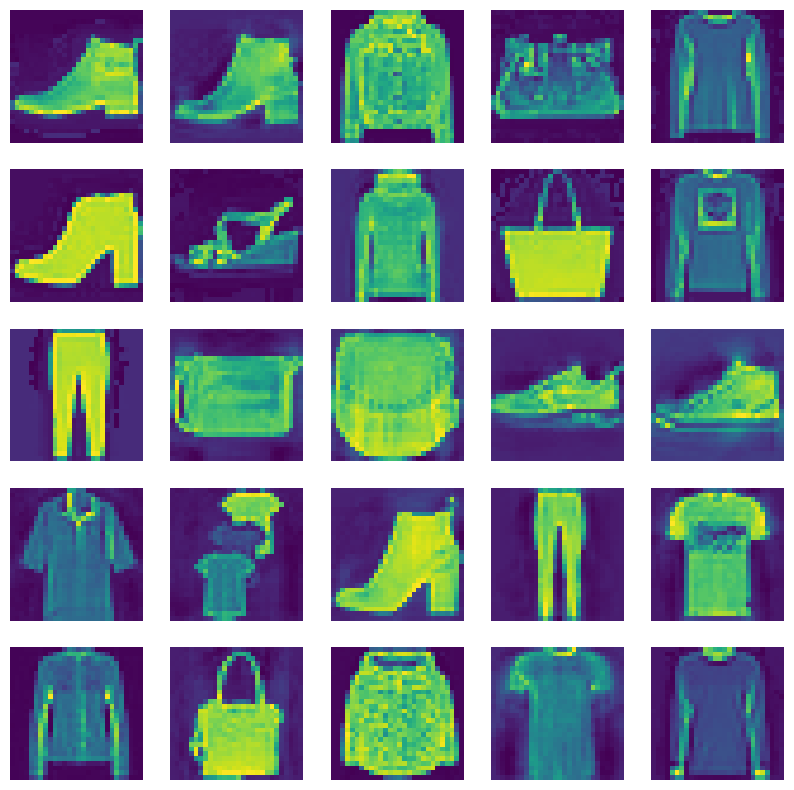

In [82]:
_, axs = plt.subplots(5, 5, figsize=(10, 10))
axs = axs.flatten()

c = model.layer0.centers.data.cpu().numpy().reshape(-1, 28,28)
imgs = c[:len(axs)]

for img, ax in zip(imgs, axs):
    ax.imshow(img)
    ax.set_axis_off()

plt.show()

#### Test for random image sample

In [83]:
with torch.no_grad():
    inputs = torch.rand(10, 28*28).to(device)*2-1
    xo = model.layer0(inputs)
    xo = model.scale_shift(xo)
    xo = model.softmax(xo).data

In [84]:
# xo.argmax(dim=1)
xo.max(dim=1)

torch.return_types.max(
values=tensor([0.8713, 0.7988, 0.8372, 0.8490, 0.8329, 0.9013, 0.8317, 0.7992, 0.8992,
        0.8490]),
indices=tensor([12, 12, 12, 12, 12, 12, 12, 12, 12, 12]))

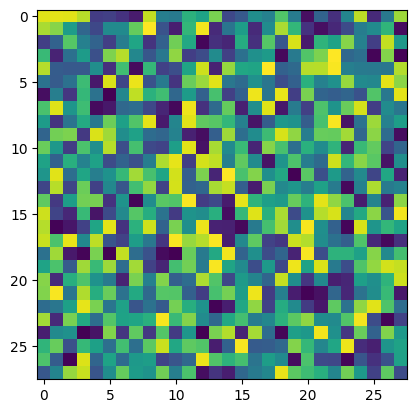

In [85]:
j=0
plt.imshow(inputs[j].reshape(28,28))

In [86]:
i = -1
nearest = torch.argsort(xo[j], descending=True)
nearest

tensor([ 12,  49,  75,  79,  78,  55,  50,  11,  99,  52,  90,  42,  43,  33,
         19,  70,  63,  23,  59,  97,  68,  17,  14,  65,  76,  18,  69,   1,
         37,  21,  34,   7,  44,  62,  86,  15,  92, 100,  61,  20,  13,  40,
         67,  16,  72,  94,  88,  28,  27,  22,  35,   3,   2,  83,  51,  71,
         89,  81,  29,  54,  73,   6,  56,  66,  82,  80,   9,  30,  64,  46,
         93,  24,  41,   0,  60,  36,  95,  39,   4,  74,  45,  84,  87,  38,
          5,  77,  53,  10,  25,   8,  98,  31,  57,  47,  91,  58,  96,  32,
         26,  48,  85])

In [87]:
xo.shape

torch.Size([10, 101])

prob: tensor(0.8713)


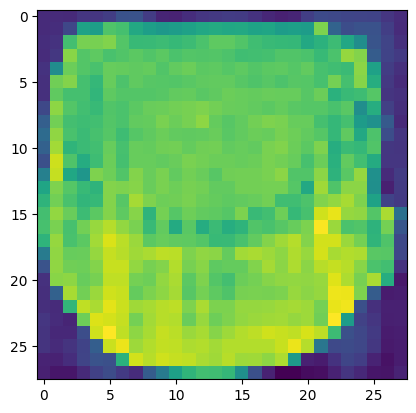

In [88]:
i+=1
print("prob:", xo[0][nearest[i]])
try:
    plt.imshow(model.layer0.centers.data[nearest[i]].reshape(28,28))
except:
    pass

In [89]:
with torch.no_grad():
    xo_ = model.activ(xo)
    xo_ = model.layer1(xo_).data

In [90]:
xo_.argmax(dim=1)

tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8])

In [91]:
#  model.layer1.weight[1], model.layer1.weight[10]

In [92]:
## scaling of softmax activation
torch.exp(model.activ.beta)

tensor([[1.1241, 1.0119, 1.9450, 1.1579, 1.0188, 1.7765, 1.3227, 1.0078, 1.0879,
         1.4334, 1.0293, 0.9827, 1.0271, 0.9983, 1.0042, 2.1408, 1.3198, 1.0189,
         1.0135, 1.0142, 1.9570, 1.0606, 1.4478, 1.0031, 1.0450, 1.8707, 2.1296,
         1.1418, 1.1471, 1.1908, 0.9609, 1.4076, 1.0340, 0.9910, 0.9680, 0.9704,
         1.3003, 1.0028, 1.8305, 1.1896, 1.0765, 1.6413, 0.9702, 1.0035, 1.0140,
         1.0662, 1.1118, 1.3644, 1.1338, 1.0625, 1.0060, 2.0683, 1.0099, 1.1419,
         1.0769, 1.0190, 1.3671, 1.9457, 1.2847, 1.0072, 1.1798, 2.4013, 1.6528,
         1.0013, 1.1408, 0.9909, 1.0086, 1.4583, 0.9842, 1.5988, 1.0011, 1.0272,
         1.0135, 1.1740, 1.3596, 1.0078, 0.9813, 1.3964, 0.9755, 1.0516, 1.6637,
         1.0945, 1.6805, 1.2745, 1.1708, 2.3161, 1.0410, 1.1406, 1.7569, 1.0267,
         0.9693, 1.3486, 0.9923, 1.3528, 1.0102, 1.3063, 1.2903, 1.0135, 1.0814,
         1.0169, 1.1570]], grad_fn=<ExpBackward>)

In [93]:
imgs.min(), imgs.max()

(-1.3888541, 1.2159096)

In [94]:
model.layer1.weight.data[:,5]

tensor([-1.6275, -1.5066, -1.4746, -1.7882, -1.5471, -0.9373, -1.5725, -1.5986,
        -1.7378,  2.5583, -0.4472])

## Adverserial Test

In [95]:
import foolbox as fb
import foolbox.attacks as fa

In [143]:
fmodel = fb.PyTorchModel(model.eval(), bounds=(-1, 1), device=device)
# fmodel = fb.PyTorchModel(model.eval(), bounds=(-10, 10), device=device)


# attack = fa.LinfPGD()
# attack = fa.L2AdamPGD()
attack = fa.FGSM()
# epsilons = [0.0, 0.001, 0.01, 0.03, 0.1, 0.3, 0.5, 1.0]

In [144]:
count = 0
failed = 0
rejected = 0
x_rejected = 0
for i, (xx, yy) in enumerate(tqdm(test_loader)):
    xx = xx.reshape(-1, 28*28)
    
    yout = model(xx)
    reject_out = yout.argmax(dim=1) == 10
    reject_hid = model.temp_maximum.max(dim=1)[1] == model.hidden_dim
    reject = torch.bitwise_or(reject_out, reject_hid)
    x_rejected += int(reject.type(torch.float32).sum())
    
    _, advs, success = attack(fmodel, xx, yy, epsilons=0.5)   
    yout = model(advs)
    reject_out = yout.argmax(dim=1) == 10
    reject_hid = model.temp_maximum.max(dim=1)[1] == model.hidden_dim
    reject = torch.bitwise_or(reject_out, reject_hid)
#     reject = reject_out
    rejected += int(reject.type(torch.float32).sum())
    
    fail = torch.bitwise_and(success, ~reject).type(torch.float32).sum()
#     fail = success.type(torch.float32).sum()
    failed += int(fail)    
    count += len(xx)

#     break

100%|███████████████████████████████████████████████████| 200/200 [00:02<00:00, 96.50it/s]


In [145]:
# success
model.layer0.epsilon

-7.0

In [146]:
count, failed, rejected, x_rejected

(10000, 4839, 4420, 1556)

In [147]:
(failed+x_rejected)/count

0.6395

In [128]:
# model.temp_maximum.max(dim=1)[1]

In [129]:
# yout.argmax(dim=1)

In [142]:
model.layer0.epsilon = -7.0
# model.layer0.epsilon = -1.5

In [49]:
"""
- not using \std on dists causes the centers to move very little from initialization (even with large lr)... 
        and have better adverserial rejection
- norm does not seem to work like std (poor optimization)
- not clipping adverserial examples [0-1] causes less attack success.. (maximum of +-1.5 with FSGM)
"""
print()

In [50]:
advs

tensor([[-1.0000, -1.0000, -1.0000,  ..., -0.5000, -0.5000, -1.0000],
        [-0.5000, -1.0000, -1.0000,  ..., -0.5000, -0.5000, -0.5000],
        [-1.0000, -0.5000, -1.0000,  ..., -0.4686, -1.0000, -1.0000],
        ...,
        [-0.5000, -0.5000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-0.5000, -0.5000, -0.5000,  ..., -1.0000, -1.0000, -0.5000],
        [-1.0000, -1.0000, -0.5000,  ..., -1.0000, -1.0000, -0.5000]])

In [51]:
advs.max()

tensor(1.)